# Homework 1 (Total Points: 175)



Learning Goals:
- Learn how to load a dataset and process it.
- Learn how to implement several IR methods (TFIDF, BM25, QL) and understand their weaknesses & strengths.
- Learn how to evaluate IR methods


**NOTE 1**: Only the code (`TODO: Implement this!` denotes these sections) is graded. The 'theory' questions in this assignment serve as a preparation for the exam and to facilitate a deeper understanding of the course content. These questions (denoted by `TODO: Answer this!`) have no points assigned to them, but **need** to be filled out before submission.  

**NOTE 2**: You can use the `nltk`, `numpy` and `matplotlib` libraries here. Other libraries, e.g., `gensim` or `scikit-learn`, may not be used. 

**NOTE 3**: The notebook you submit has to have the student ids, seperated by underscores (E.g., `12341234_12341234_12341234.ipynb`). 

**NOTE 4**: Make sure to check that your notebook runs before submission. A quick way to do this is to restart the kernel and run all the cells.  

---
Additional Resources: 
-  Sections 2.3, 4.1, 4.2, 4.3, 5.3, 5.6, 5.7, 6.2, 7, 8 of [Search Engines: Information Retrieval in Practice](https://ciir.cs.umass.edu/downloads/SEIRiP.pdf)


###  References (used to answer the theoretical questions)
- [Jaime Arguello] https://ils.unc.edu/courses/2013_spring/inls509_001/lectures/10-EvaluationMetrics.pdf

- [Croft *et al.*] https://ciir.cs.umass.edu/downloads/SEIRiP.pdf

- [Manning *et al.*] https://nlp.stanford.edu/IR-book/pdf/irbookonlinereading.pdf


In [1]:
# imports 
# TODO: Ensure that no additional library is imported in the notebook. 
# TODO: Only the standard library and the following libraries are allowed:

import os
import zipfile
from functools import partial

import nltk
import requests
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from ipywidgets import widgets
from IPython.display import display, HTML
from IPython.html import widgets
from collections import namedtuple

%matplotlib inline

/home/alex/anaconda3/lib/python3.6/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


## Section 1: Text Processing (20 points)

In this section, we will load the dataset and learn how to clean up the data to make it usable for an IR system. 

We are using the [CACM dataset](http://ir.dcs.gla.ac.uk/resources/test_collections/cacm/), which is a small, classic IR dataset, composed of a collection of titles and abstracts from the journal CACM. It comes with relevance judgements for queries, so we can evaluate our IR system. 

The following cell downloads the dataset and unzips it to a local directory

In [2]:
def download_dataset(folder_path = "./datasets/"):
    
    os.makedirs(folder_path, exist_ok=True)
    
    file_location = os.path.join(folder_path, "cacm.zip")
    
    # download file if it doesn't exist
    if not os.path.exists(file_location):
        
        url = "https://surfdrive.surf.nl/files/index.php/s/M0FGJpX2p8wDwxR/download"

        with open(file_location, "wb") as handle:
            print(f"Downloading file from {url} to {file_location}")
            response = requests.get(url, stream=True)
            for data in tqdm(response.iter_content()):
                handle.write(data)
            print("Finished downloading file")
    
    if not os.path.exists(os.path.join(folder_path, "train.txt")):
        
        # unzip file
        with zipfile.ZipFile(file_location, 'r') as zip_ref:
            zip_ref.extractall(folder_path)
        
download_dataset()

You can see a brief description of each file in the dataset by looking at the README file

In [3]:
##### Read the README file 
# !cat ./datasets/README
#####

----
We are interested in 4 files:
- `cacm.all` : Contains the text for all documents. Note that some documents do not have abstracts available. 
- `query.text` : The text of all queries
- `qrels.text` : The relevance judgements
- `common_words` : A list of common words. This may be used as a collection of stopwords

In [4]:
##### The first 45 lines of the CACM dataset forms the first record
# We are interested only in 3 fields. 
# 1. the '.I' field, which is the document id
# 2. the '.T' field (the title) and
# 3. the '.W' field (the abstract, which may be absent)
# !head -45 ./datasets/cacm.all
#####

---

Now, write a function to read in the `cacm.all` file. Note that each document has a variable number of lines. The `.I` field denotes a new document

In [5]:
# TODO: Implement this! (4 points)
def read_cacm_docs(root_folder = "./datasets/"):
    """
        Reads in the CACM documents. The dataset is assumed to be in the folder "./datasets/cacm" be default
        Returns: A list of 2-tuples: (doc_id, document), where 'document' is a single string created by 
            appending the title and abstract (seperated by a "\n"). 
            In case the record doesn't have an abstract, the document is composed only by the title
    """
     
    with open(root_folder+"cacm.all") as file:
        
        text = file.read()
        documents = text.split(".I ")[1:]
        
        res = []
        
        for doc in documents:
            
            split_doc = doc.split("\n.")
            
            ID = split_doc[0]
            
            T = [d for d in split_doc if d[0]=="T"][0][2:]
            
            W = [d for d in split_doc if d[0]=="W"]
            if W: T+= "\n" + W[0][2:]
            
            res.append((ID, T))

    return res
    
docs = read_cacm_docs()

In [6]:
##### 
assert len(docs) == 3204, "There should be exactly 3024 documents"
##### 

---

Next, let us read the queries. They are formatted similarly: 

In [7]:
##### The first 15 lines of 'query.text' has 2 queries
# We are interested only in 2 fields. 
# 1. the '.I' - the query id
# 2. the '.W' - the query
# 3. the '.W' field (the abstract, which may be absent)
# !head -15 ./datasets/query.text
#####

---

Now, write a function to read in this file:

In [8]:
# TODO: Implement this! (3 points)
def read_queries(root_folder = "./datasets/"):
    """
        Reads in the CACM queries. The dataset is assumed to be in the folder "./datasets/" be default
        Returns: A list of 2-tuples: (query_id, query)
    """
    
    queries = [] 
    with open(root_folder+"query.text") as file:
        queries_string = file.read()
        for q in queries_string.split(".I ")[1:]:
            """
            q_ = q.split('.W\n ')
            query_id = q_[0].strip('\n')
            query = q_[1].split("\n.N")[0].replace('\n', ' ').replace('/', '')
    
            queries.append((query_id, query))
            """
            split_query = q.split("\n.")
            
            ID = split_query[0]
            
            W = [q for q in split_query if q[0]=="W"][0][2:]
            W = W.replace('\n', ' ').replace('/', '')
            
            queries.append((ID, W))
            
    return queries
   
queries = read_queries()

In [9]:
##### 
assert len(queries) == 64 and all([q[1] is not None for q in queries]), "There should be exactly 64 queries"
##### 

---

Read in the stop words:

In [10]:
# !head ./datasets/common_words

In [11]:
# TODO: Implement this! (3 points)
def load_stopwords(root_folder = "./datasets/"):
    """
    Load the stopwords
    Output: A set of stopwords
    """
    with open(root_folder+'common_words') as file:
        text = file.read()
        words = text.split('\n')
        words.remove('')
        return list(set(words))

stopwords = load_stopwords()
assert len(stopwords) == 428

--- 

We can now write some basic text processing functions. A first step is to tokenize the text. You may use any tokenizer available in the `nltk` library:

In [12]:
# TODO: Implement this! (5 points)
nltk.download('punkt')
def tokenize(text):
    """
        Tokenize the text. 
        Input: text - a string
        Output: a list of tokens
    """
    return nltk.tokenize.word_tokenize(text)

[nltk_data] Downloading package punkt to /home/alex/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:
#####
text = "the quick brown fox jumps over the lazy dog."
tokens = tokenize(text)
print(tokens)
#####

['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog', '.']


---
*Answer the following questions*: 
- Why is stemming necessary, in particular for IR?
    - Stemming is the process of reducing inflected and derived forms of a word to a common basic form. This is done by using a set of fixed rules (for example always removing the ending -ings) and applying it to all words of all documents. This way, we can identify documents with similar content that only used different word forms. To exemplify, we can find that documents that contain the words "democratic", "democracy" or "democratization" are all relevant for a query that contains the word "democrat". This can help to increase the recall of our search.
      
- Is there any setting (domain, scenario, etc) in which stemming can hurt performance? Illustrate with an example
    - When we perform stemming we perform a generalisation of words, which implicitly means that we might decrease our precision. Consider for example the case that we have a query containing the word "withing". When our stemming algorithm removes the ending "-ing" whenever present, we will now find all documents that contain the word "with" to be relevant. Similarily, think of the words "experiment" and "experience", who might both be stemmend to "experi" and therefore wrongly associated.

Write a function to stem tokens. Again, you can use the `nltk` library for this

In [14]:
# TODO: Implement this! (5 points)
def stem_token(token):
    """
        Stem the given token, using any stemmer available from the nltk library
        Input: a single token
        Output: the stem of the token
    """
    stemmer = nltk.stem.PorterStemmer()
    return stemmer.stem(token)
    

In [15]:
####
print([stem_token(t) for t in tokens])
tokens_ = [
    'caresses', 'flies', 'dies', 'mules', 'denied',
    'died', 'agreed', 'owned', 'humbled', 'sized',
    'meeting', 'stating', 'siezing', 'itemization',
    'sensational', 'traditional', 'reference', 'colonizer',
    'plotted']
print([stem_token(t) for t in tokens_])
####

['the', 'quick', 'brown', 'fox', 'jump', 'over', 'the', 'lazi', 'dog', '.']
['caress', 'fli', 'die', 'mule', 'deni', 'die', 'agre', 'own', 'humbl', 'size', 'meet', 'state', 'siez', 'item', 'sensat', 'tradit', 'refer', 'colon', 'plot']


---

*Answer the following questions*: 
- Another processing step (not done here) is to use n-grams. Illustrate why you would want to use n-grams in IR with an example.  
    - Currently, we represent every documement as a bag-of-words which means that we completely disregard the word order. This is different when using a n-gram language model, where we represent the document as a bag of sequences of length n. By doing so, we implicitly model more context and will most likely end up with a more expressive representation of the document's content. Consequently, we can find documents that contain phrases from the query. Croft et al. give the example of the query "black sea". Clearly, documents that contain "black sea" are more likely to be relevant to our query than documents containing the words "black"and "sea" individually.
   
- Usage of n-grams exacerbates some problems ex. in bi-gram language models. What is this problem? Suggest one solution 
    - The impact of phrases on the relevance of documents might not always be as clear as in the "black sea" example. For example when we consider the query "art supplies", a  document that does not contain the exact query but the words "art"/"arts"/"artist"/"supplies"/"supply"/etc. individually might be very relevant. A possible solution would be to consider both bigrams and single stemmed words contained in documents and then weight the occurences against each other to obtain an overall relevance ranking.
   

--- 

The following function puts it all together. Given a string, it tokenizes it, and processes it according to the flags that you set.

In [16]:
#### Putting it all together
def process_text(text, stem=False, remove_stopwords=False, lowercase_text=False):
    
    tokens = []
    for token in tokenize(text):
        if remove_stopwords and token.lower() in stopwords:
            continue
        if stem:
            token = stem_token(token)
        if lowercase_text:
            token = token.lower()
        tokens.append(token)

    return tokens
#### 

Let's create two sets of pre-processed documents

In [17]:
# In this configuration:
# Don't preprocess the text, except to tokenize 
config_1 = {
  "stem": False,
  "remove_stopwords" : False,
  "lowercase_text": True
} 


# In this configuration:
# Preprocess the text: stem and remove stopwords
config_2 = {
  "stem": True,
  "remove_stopwords" : True,
  "lowercase_text": True, 
} 


We can now process the documents and queries according to the configuration specified above

In [18]:
####
doc_repr_1 = []
doc_repr_2 = []
for (doc_id, document) in docs:
    doc_repr_1.append((doc_id, process_text(document, **config_1)))
    doc_repr_2.append((doc_id, process_text(document, **config_2)))  
####


--- 

## Section 2: Indexing (10 points)


A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


### Building an index

A retrieval function usually takes in a query document pair, and scores a query against a document.  Our document set is quite small - just a few thousand documents. However, consider a web-scale dataset with a few million documents. In such a scenario, it would become infeasible to score every query and document pair. In such a case, we can build an inverted index. From Wikipedia:

> ... , an inverted index (also referred to as a postings file or inverted file) is a database index storing a mapping from content, such as words or numbers, to its locations in a table, .... The purpose of an inverted index is to allow fast full-text searches, at a cost of increased processing when a document is added to the database. ...


Consider a simple inverted index, which maps from word to document. This can improve the performance of a retrieval system significantly. In this assignment, we consider a *simple* inverted index, which maps a word to a set of documents. In practice, however, more complex indices might be used.  


---

In this assignment we will be using an index created in memory, since our dataset is tiny. To get started, build a simple index that maps simply counts the number of tokens present in a document. This index  is built using a python dictionary.

*Answer the following questions*:
- What is the time complexity of retrieving a list of documents from a python `dict` object? 
    - Note that this answer assumes a query length of 1.
    Assuming the dictionary to be an inverted index then the keys are the tokens and we only have to access the dictionary once to retrieve the document list. Accessing an element in a python dict is in constant time, i.e. $O(1)$, because a dict is implemented as a hash table. 
    Assuming the dictionary is maps from document id to tokens in the document, we have to access the dictionary multiple times. We would have a total complexity of $O(D\cdot n)$ where $D$ is the number of documents and $n$ is the average length of a word list associated with a document. This is because searching a list of length $n$ is in $O(n)$, assuming the list is not ordered. We have to search the token list for each document.  Note that the average runtime of this could be reduced in practice if the list of words associated with a document was in alphabetical order.
    
- Consider the case with a 10 million documents. What is the time complexity of retrieval with an inverted index (assuming you can fit the entire index in memory)? (Hint: Consider length of a query $|q|$) 

    - If we would have a index where we have the documents as keys, then the time complexity would be $O(\#documents)$ since we need to look for each document in the list of tokens to see if it contains words from the query. If we have an inverted index, the time complexity of retrieving a document list for a query is independent of the number of documents, but instead it dependents on the query length: $O(|q|)$. This reduces the time complexity since the query length is much smaller than the number of documents
    
- For a large enough collection, we cannot store an index in memory. How is this tackled in practice (briefly explain)? Comment on the time complexity. 
    - If the inverted index is too big for our runtime memory, we can make use of merging. Instead of having one index, we write multiple partial indices to the disk. At retrieval time we load one index after the other and store the partial result, and then we merge all partial results together. 
    
- Mention a use-case in which a simple index (from word -> doc_id) might not suffice anymore. How would you modify the index to suit this use-case (if you can!)  
    - An example information that could be stored in the posting next to the document ID is the word count. It is helpful in finding relevant documents because it allows us to distinguish documents that focus on a specific topic from those who just briefly mention it. As an example, we can think of the query "Spaghetti Carbonara". A document that describes how to make the dish is very likely to repeat both words multiple times whereas some document about planning your vacation in Italy might address in one sentence a restaurant where a nice Spaghetti Carbonara can be found. 

In [19]:
# TODO: Implement this! 10 points
def build_tf_index(documents):
    """
    Build an inverted index (with counts). The output is a dictionary which takes in a token
    and returns a list of (doc_id, count) where 'count' is the count of the 'token' in 'doc_id'
    Input: a list of documents - (doc_id, tokens) 
    Output: An inverted index. [token] -> [(doc_id, token_count)]
    """
    inverted_index = {}
 
    for doc_id, tokens in documents:
        token_counts = {}
        for token in tokens:
            if token not in token_counts.keys():
                token_counts[token] = 0 
            token_counts[token] += 1  

        for token, count in token_counts.items():
            if token not in inverted_index.keys(): 
                inverted_index[token] = [] 
            inverted_index[token].append((doc_id, count))

    return inverted_index
 
# Create the 2 indices
tf_index_1 = build_tf_index(doc_repr_1)
tf_index_2 = build_tf_index(doc_repr_2)

# This function returns the correct index 
def get_index(index_set):
    assert index_set in {1, 2}
    return {
        1: tf_index_1,
        2: tf_index_2
    }[index_set]

# This function correctly pre-processes the text given the index set
def preprocess_query(text, index_set):
    assert index_set in {1, 2}
    if index_set == 1:
        return process_text(text, **config_1)
    elif index_set == 2:
        return process_text(text, **config_2)
    

--- 

## Section 3: Retrieval  (80 points)

Now that we have cleaned and processed our dataset, we can start building simple IR systems. 

For now, we consider *simple* IR systems, which involve computing scores from the tokens present in the document/query. More advanced methods are covered in later assignments.

We will implement the following methods in this section:
- TF-IDF
- BM25
- Query Likelihood Models

--- 

### Ranking functions


Probably the simplest IR model is the Bag of Words (BOW) model. Implement a function that scores a query against a document using this model.   

Note that you can use either the count of the token or 'binarize' it i.e set the value equal to 1 if the token appears.   


**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

In [20]:
# TODO: Implement this! 10 points
def bow_search(query, index_set):
    """
        Perform a search over all documents with the given query. 
        Note #1: You have to use the `get_index` function created in the previous cells
        Note #2: You can binarize the counts if you wish to
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """

    index = get_index(index_set)
    query_preprocessed = preprocess_query(query, index_set)

    
    bow = {} 
    for token in query_preprocessed: 
        if token not in index:
            continue
        for doc_id, count in index[token]: 
            if doc_id not in bow:
                bow[doc_id] = {}
            if token not in bow[doc_id]: 
                # binarize
                bow[doc_id][token] = 1 
                
    # bow:{doc_id: {token: count}} 
    # note that count here is always 1 bc we chose to binarize it
    
    relevance = [] 
    for doc_id, words in bow.items():
        score = sum(words.values()) 
        relevance.append((doc_id, score))
    relevance = sorted(relevance,key=lambda x:(-x[1],x[0]))  
    relevance = [(t[0],str(t[1])) for t in relevance]

    return relevance

*Answer the following questions*: 
- The BOW model is might not be a good choice for use in IR. Why? 
    - The number of occurences of a word within a document (i.e. the *word count / term-frequency*) is on its own not a reliable measure of how representative the word is for the document's content. This is because even after removing very common stop words like 'a'/'the'/etc. , there are still words that occur more often within written language than others. One way to deal with this problem would be to binarize the term-frequency (i.e. set 1 for occurence and 0 for non-occurence). However, this way we completely disregard how often a term occurs within a document, which is an indicator of how representative a word is for the document's content. Another way to obtain a measure for how representative a word is for a document's content is to normalize the term-frequency (tf) by the inverse document frequency (idf). This way, we value the occurence of a word that is generally rare higher than for example the 3-times occurence of a very frequent word.
    

In [21]:
####
docs_by_id = dict(docs)
def print_results(docs, len_limit=50):    
    for i, (doc_id, score) in enumerate(docs):
        doc_content = docs_by_id[doc_id].strip().replace("\n", "\\n")[:len_limit] + "..."
        print(f"Rank {i}({score:.2}): {doc_content}")

test_bow = bow_search("report this", index_set=1)[:5]
print(f"BOW Results:")
print_results(test_bow)
#### replace

BOW Results:
Rank 0(2): Multiword List Items\nThe list concept as original...
Rank 1(2): The SMART Automatic Document Retrieval System-An I...
Rank 2(2): Remote, On-Line, Real-time Computer Diagnosis\nof ...
Rank 3(2): Computing Capabilities at Western European Univers...
Rank 4(2): A Fortran Technique for Simplifying Input to Repor...


Before we implement the tf-idf scoring functions, let's first write a function to compute the document frequencies of all words.  

In [22]:
# TODO: Implement this! (5 points)
def compute_df(documents):
    """
        Compute the document frequency of all terms in the vocabulary
        Input: A list of documents
        Output: A dictionary with {token: document frequency)
    """
    
    df = {}
    for document in documents: 
        for token in list(set(document)): 
            if token not in df.keys():
                df[token] = 0
            df[token] += 1 
                        
    return df
    

# get the document frequencies of each document
df_1 = compute_df([d[1] for d in doc_repr_1])
df_2 = compute_df([d[1] for d in doc_repr_2])

def get_df(index_set):
    assert index_set in {1, 2}
    return {
        1: df_1,
        2: df_2
    }[index_set]

Next, implement a function that computes a tf-idf score given a query.      

In [23]:
# TODO: Implement this! 10 points
def tfidf_search(query, index_set):
    """
        Perform a search over all documents with the given query using tf-idf. 
        Note #1: You have to use the `get_index` (and the `get_df`) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    
    index = get_index(index_set) # {token: [('doc_id',count)]}
    df = get_df(index_set) # {token: document_frequency}
    query_preprocessed = preprocess_query(query, index_set) #[token]
       
    N = len(read_cacm_docs())
    idf = {token: np.log(N/doc_freq) for token, doc_freq in df.items()}
    
    
    # [from the ITIR book, chapter 6]:
    # assign [tf(d,t)] to be equal to the number 
    # of occurrences of term t in document d
    tf = {} # {doc_id : {token: count}}
    
    for token in query_preprocessed: 
        
        # query token might be in none of the documents
        if token not in index: continue
            
        for doc_id, count in index[token]:
            if doc_id not in tf: 
                tf[doc_id] = {}
            if token not in tf[doc_id]: 
                tf[doc_id][token] = count 
          
    relevance = [] 
    for doc_id, words in tf.items(): # for every document
        score = sum([tf * idf[word] for word, tf in words.items()])
        relevance.append((doc_id, score))
    relevance = sorted(relevance,key=lambda x:(-x[1],x[0]))   
    relevance = [(t[0],str(t[1])) for t in relevance]

    return relevance

In [24]:
####
test_tfidf = tfidf_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_tfidf)
####

TFIDF Results:
Rank 0(23): Rejuvenating Experimental Computer Science\nThis r...
Rank 1(19): An Information Algebra - Phase I Report-Language\n...
Rank 2(11): ALGOL 60 Confidential\nThe ALGOL 60 Report,* when ...
Rank 3(7.): A Fortran Technique for Simplifying Input to Repor...
Rank 4(7.): Control Procedures for Data Communication-An ASA P...


*Answer the following questions*: 
- It is generally not advisable to use the naive version of tf-idf. Why?
    - The importance of the document scales linearly with the number of term occurences. 
    
    Cited from Crof *et al.*:We observe higher term frequencies in longer documents, merely because longer documents tend to repeat the same words over and over again. So the naive version of tf-idf would overestimate the relevance of this longer document.
    
    
- Illustrate with an example why using a sublinear scaling for TF is preferable in some cases.  
    - Consider the following extreme example: supposed we were to take a document d and create a new document d′ by simply appending a copy of d to itself. While d ′ should be no more relevant to any query than d is, the use of the naive version of tf-idf would assign it twice as high a score as d. 
    
    Cited from Crof *et al.*:A document collection can contain documents of many different lengths. Although normalization accounts for this to some degree, long documents can have many terms occurring once and others occurring hundreds of times. Retrieval experiments have shown that to reduce the impact of these frequent terms, it is effective to use the logarithm of the number of term occurrences in tf weights rather than the raw count (which is what sublinear scaling for TF does). 
    

--- 

*Answer the following questions*: 
- An alternative way to compute a query<>document score is to vectorize both the query and document (where each dimension corresponds to a token), and compute a score. The score can be computed using a dot product between the query and the document vectors. Why is the cosine similary function a better choice, particularly in IR? 
    - The cosine similarity between the vector representations of two documents measure similarity as the cosine of the angle between the two vectors. This measure is favorable compared to the naive tf-idf scores, because it disregards the length of the vector representation. Instead, we look at the direction of the vector representation, which is the ratio of counts of query terms in the document. This way we implicitly account for the problem descriebd in the previous question: If we just append a document to itself, the ratio between the counts of query words stays the same which means the vetor representation has the same direction.
  
- What is the time complexity of a search if we are using the vector space method mentioned in the previous question? What is the time complexity if we're using an index (assume that it fits in memory)? Assume $N$ is the number of documents and $|q|$ is the length of a query. 
    - The time complexity is the same. In both cases we need to sort the documents based on relevance since we need to rank them. When assuming we already have the relevance scores and we use the Timsort algorithm in python, the time complexity would be  $O(n \cdot \log{n})$. Note that the obtaining the cosine similarity between the vectors is linear in time. 

--- 

#### Query Likelihood Models

In this section you will implement a simple query likelihood model. 

First, let use implement a naive version of a QL model, assuming a multinomial unigram language model (with a uniform prior over the documents). 

**Note:** Make sure you use the `get_index` function to retrieve the correct index, and call `preprocess_query` with the correct index!

--- 

*Answer the following questions*: 
- Write down the formula for computing the query likelihood, assuming a multinomial unigram language model. 
    - \begin{align}P(Q|D)=\prod_{i=1}^nP(q_i|D)\end{align} where $q_i$ is a query word, and there are $n$ words in the query. The obvious choice for the language model probabilities $P(q_i|D)$ would be the maximumlikelihood estimate, i.e. \begin{align}P(q_i|D)=\frac{f_{q_i,D}}{|D|}\end{align} with $f_{q_i,D}$ the count of $q_i$ in $D$ and $|D|$ the number of words in $D$.
- What problem does this naive method have? Suggest a simple way to fix it.
    - The problem is that as soon as any word of the query $Q$ is missing in a document $D$, the score from the query likelihood model, i.e. $P(Q|D)$, is zero. This is problemtic because especially for longer queries it is likely that the document will not contain all the query words which results in that a lot of documents will receive a relevance score of zero. Also we cannot distinguish between documents that miss different numbers of query words: e.g. the relevance score for documents missing 6 out of 7 query words will be zero, while documents missing only 1 query word will also get a score of zero. A simple way to fix this is to do smoothing: We lower the probablity estimates for words seen in the document text and then distribute the leftover probability to the words that are not present:
    \begin{align*}
        (1-\alpha_{D})P(q_i | D) + \alpha_D P(q_i|C)
    \end{align*}
    Here $\alpha_D$ is a coefficient that controls the probability assigned to unseen words.
    \begin{align}\end{align} We make use of the probability of query words in the document collection $C$, i.e.\begin{align}P(q_i|C) = \frac{f_{q_i,C}}{|C|} \end{align}with $f_{q_i,C}$ the count of $q_i$ in the collection of all documents and $|C|$ the number of words in all documents. 
    We can now decide to set $\alpha_D$ to a constant $0 \geq \lambda \leq 1$.
    This results in the *Jelinek-Mercer* method where the score for a query term is given by:
    \begin{align}P\left(q_{i} | D\right)=(1-\lambda) \frac{f_{q_{i}, D}}{|D|}+\lambda \frac{f_{q_i,C}}{|C|} \end{align} with $\lambda$ determining the degree of smoothing. We used this form of smoothing in our implementation
    
    In another approach known as *Dirichlet* smoothing, $\alpha_D$ is not just simply a constant, but is dependent on document length:
       \begin{align*}
           \alpha_D = \frac{\mu}{|D|+\mu}
       \end{align*}
       with $\mu$ as hyperparameter that needs to be tuned empirically.
       
  Reference: Croft *et al.*

In [25]:
####
def doc_lengths(documents):
    doc_lengths = {doc_id:len(doc) for (doc_id, doc) in documents}
    return doc_lengths

doc_lengths_1 = doc_lengths(doc_repr_1)
doc_lengths_2 = doc_lengths(doc_repr_2)

def get_doc_lengths(index_set):
    assert index_set in {1, 2}
    return {
        1: doc_lengths_1,
        2: doc_lengths_2
    }[index_set]
####

In [26]:

# TODO: Implement this! 15 points
def naive_ql_search(query, index_set):
    """
        Perform a search over all documents with the given query using a naive QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set) # {token: [('doc_id',count)]}
    doc_lengths = get_doc_lengths(index_set) # {doc_id: len(doc)}
    query_preprocessed = preprocess_query(query, index_set) #[token]
    
    # scores for every document and query_word
    scores = {i : {q_i: 0 for q_i in query_preprocessed} 
                      for i in doc_lengths.keys()}
    
    for q_i in query_preprocessed:
        
        #### NEW ########################
        if q_i not in index: continue
        #################################
            
        for doc_id, count in index[q_i]:
            scores[doc_id][q_i] = count / doc_lengths[doc_id]
    
    relevance = [] 
    for doc_id, count_dict in scores.items():
        score = np.prod(list(count_dict.values()))
        relevance.append((doc_id, score))
    
    relevance = sorted(relevance,key=lambda x:(-x[1],x[0]))   
    relevance = [(t[0],str(t[1])) for t in relevance]
    return relevance

In [27]:
####
test_naiveql = naive_ql_search("report", index_set=1)[:5]
print(f"TFIDF Results:")
print_results(test_naiveql)
####

TFIDF Results:
Rank 0(0.): A CRT Report Generating System...
Rank 1(0.): A Report Writer For COBOL...
Rank 2(0.): ALGOL Sub-Committee Report - Extensions...
Rank 3(0.): Supplement to the ALGOL 60 Report...
Rank 4(0.): Report on the Algorithmic Language ALGOL 60...


Now, let's implement a (slightly more) complex QL model. This model should 'fix' the issue with the previous method. If your model requires hyperparameters, set a reasonable value. 

In [28]:
# TODO: Implement this! 20 points
def ql_search(query, index_set, l=0.7):
    """
        Perform a search over all documents with the given query using a appropriate QL model. 
        Note #1: You have to use the `get_index` (and get_doc_lengths) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set) # {token: [('doc_id',count)]}
    doc_lengths = get_doc_lengths(index_set) # {doc_id: len(doc)}
    query_preprocessed = preprocess_query(query, index_set) #[token]
    
    len_C = sum(doc_lengths.values()) # len of all documents
    
    # scores for every document and query_word
    scores = {i : {q_i: 0 for q_i in query_preprocessed} 
                      for i in doc_lengths.keys()}
    
    for q_i in query_preprocessed: # for every query word q_i
        
        # count how often q_i occurs overall
        count_C = 0
        if q_i in index: 
            count_C = sum([count for _,count in index[q_i]])
            
        # calculate P(q_i|C) (same for all documents)
        P_qi_C = count_C / len_C
        
        # for every document
        for doc_id in doc_lengths.keys(): 
            scores[doc_id][q_i] = l * P_qi_C
            
        ###### NEW #################################
        if q_i not in index: continue
        ############################################
            
        # update if doc contains q_i    
        for doc_id, count in index[q_i]: 
            # caculate P(q_i|D)
            P_qi_D = count / doc_lengths[doc_id]
            scores[doc_id][q_i] += (1-l) * P_qi_D 
            
    relevance = [] 
    for doc_id, count_dict in scores.items():
        
        score = np.prod(list(count_dict.values()))
        relevance.append((doc_id, score))
    
    relevance = sorted(relevance,key=lambda x:(-x[1],x[0]))   
    relevance = [(t[0],str(t[1])) for t in relevance]

    return relevance


In [29]:
#### Test the QL model
test_ql_results = ql_search("report", index_set=1)[:5]
print_results(test_ql_results)
print()
test_ql_results_long = ql_search("report " * 10, index_set=1)[:5]
print_results(test_ql_results_long)
####

Rank 0(0.): A CRT Report Generating System...
Rank 1(0.): A Report Writer For COBOL...
Rank 2(0.): ALGOL Sub-Committee Report - Extensions...
Rank 3(0.): Supplement to the ALGOL 60 Report...
Rank 4(0.): Report on the Algorithmic Language ALGOL 60...

Rank 0(0.): A CRT Report Generating System...
Rank 1(0.): A Report Writer For COBOL...
Rank 2(0.): ALGOL Sub-Committee Report - Extensions...
Rank 3(0.): Supplement to the ALGOL 60 Report...
Rank 4(0.): Report on the Algorithmic Language ALGOL 60...


*Answer the following questions*: 
- What happens to the query likelihood for long queries? What is a simple fix for this issue?
    - [TODO: CHECK] 
    
    ############################ OLD #################################
    
    For long queries, the calculated probbailites tend towards zero. A quick fix would be to simply scale all scores equally.
    
    ######################### NEW #################################
    
    Recall that we calculate the query likelihood by:
    \begin{align}P(Q|D)=\prod_{i=1}^nP(q_i|D)\end{align} 
    
    Important to note is that we multiply over probabilities, which are values in range $[0, 1]$. This can lead to numerical underflows if the query is long ($n$ is large). A simple fix is to calculate the query log likelihood instead. This score is rank-equivalent and allows us to get rid of the product: 
    \begin{align}\log{P(Q|D)}=\sum_{i=1}^n \log{P(q_i|D)}\end{align} 


--- 

#### BM25

In this section, we will implement the widely used and hard to beat BM25 scoring function. 


In [30]:
# TODO: Implement this! (20 points)
def bm25_search(query, index_set, k1=0.5, b=1):
    """
        Perform a search over all documents with the given query using BM25. 
        Note #1: You have to use the `get_index` (and `get_doc_lengths`) function created in the previous cells
        Note #2: You might have to create some variables beforehand and use them in this function
        Input: 
            query - a (unprocessed) query
            index_set - the index to use
        Output: a list of (document_id, score), sorted in descending relevance to the given query 
    """
    index = get_index(index_set) # {token: [('doc_id',count)]}
    doc_lengths = get_doc_lengths(index_set) # {doc_id: len(doc)}
    query_preprocessed = preprocess_query(query, index_set) #[token]
    df = get_df(index_set) # {token: document_frequency}
    
    # NOTE: Implementation according to ITIR book (Manning et al.) formula 11.32
    
    # ifd weights for every token
    N = len(doc_lengths)
    idf = {token: np.log(N/doc_freq) for token, doc_freq in df.items()}
    
    # average document length
    L_avg = sum(doc_lengths.values())/N
    
    # scores for every document and query_word
    scores = {d : {q_i: 0 for q_i in query_preprocessed} 
                      for d in doc_lengths.keys()}
    
    # for every token in the query
    for token in query_preprocessed:
            
        ######### NEW ##############
        
        # query token might be in none of the documents
        if token not in index: continue
            
        # same code as in old but without extra dict. still correct right???
        for doc_id, count in index[token]: 
            L_d = doc_lengths[doc_id]
            tf = count
            scores[doc_id][token] = (idf[token]*(k1+1)*tf)/(k1*(1-b+b*(L_d/L_avg))+tf)
            
#         ########### OLD ###############
#         token_index = {d:count for d, count in index[token]}
            
#         # for every document that contains token
#         for doc_id in token_index.keys():
            
#             L_d = doc_lengths[doc_id]
#             tf = token_index[doc_id]
            
#             scores[doc_id][token] = (idf[token]*(k1+1)*tf)/(k1*(1-b+b*(L_d/L_avg))+tf)
    
    relevance = [] 
    for doc_id, token_dict in scores.items():
        score = sum(token_dict.values())
        relevance.append((doc_id, score))
        
    relevance = sorted(relevance,key=lambda x:(-x[1],x[0]))   
    relevance = [(t[0],str(t[1])) for t in relevance]

    return relevance


In [31]:
#### Test the BM25 model
test_bm25_results = bm25_search("report", index_set=1)[:5]
print_results(test_bm25_results)
####

Rank 0(5.): A CRT Report Generating System...
Rank 1(5.): A Report Writer For COBOL...
Rank 2(5.): ALGOL Sub-Committee Report - Extensions...
Rank 3(5.): Supplement to the ALGOL 60 Report...
Rank 4(5.): Report on the Algorithmic Language ALGOL 60...




*Answer the following questions*: 
- Briefly explain how the BM25 model improves upon the tf-idf model.
    - The BM25 model is able to normalize the term frequency by the document length, preventing overestimation of the relevance of longer documents.
    
    Recall that the tf-idf model was defined:
    \begin{align}
        \mathrm{\sum_{t \in q} tf_{t,d} \times idf_{t}} 
    \end{align}
    
    The BM25 model is defined as follows (Manning *et al.*):
   
    \begin{align}
    \sum_{t \in q} \log \left[\frac{N}{\mathrm{df}_{t}}\right] \cdot \frac{\left(k_{1}+1\right) \mathrm{tf}_{t d}}{k_{1}\left((1-b)+b \times\left(L_{d} / L_{\mathrm{ave}}\right)\right)+\mathrm{tf}_{t d}}
    \end{align}
    
    Cited from Manning *et al.*: Here, $\mathrm{tf_{td}}$ is the frequency of term $t$ in document $d$, and $\mathrm{L_d}$ and $\mathrm{L_{ave}}$ are the length of document $d$ and the average document length for the whole collection. The variable $\mathrm{k_1}$ is a positive tuning parameter that calibrates the document term frequency scaling. A $\mathrm{k_1}$ value of 0 corresponds to a binary model (no term frequency), and a large value corresponds to using raw term frequency. $b$ is another tuning parameter $(0 ≤ b ≤ 1)$ which determines the scaling by document length: $b = 1$ corresponds to fully scaling the term weight by the document length, while $b = 0$ corresponds to no length normalization.

    In the BM25 model, the first term is the inverse document frequency (idf) like in the tf-idf model. The difference between the models lies in the second term: As discussed earlier, longer documents tend to have higher term frequencies while not being necessarily more relevant. The tf-idf model just uses the raw term frequency (tf), whereas the BM25 model is able to normalize the tf component by the document length. The normalizing part in the tf component is $k_{1}\left((1-b)+b \times\left(L_{d} / L_{\mathrm{ave}}\right)\right)$ where $b$ regulates the scaling of the document lenght. So for an appropriate value of $b$, this normalization helpes to make the relevance score independent of the document length. Also for certain $k_1$, the effect of $\mathrm{tf_{td}}$ can be made very non-linear. This gives a similar effect as the *sublinear scaling for TF* discussed previously, i.e. after the term occured a few times in the document additional occurences will have little impact on the relevance score. 
---

In [32]:
#### Highlighter function
# class for results
ResultRow = namedtuple("ResultRow", ["doc_id", "snippet", "score"])
# doc_id -> doc
docs_by_id = dict((d[0], d[1]) for d in docs)

def highlight_text(document, query, tol=17):
    import re
    tokens = tokenize(query)
    regex = "|".join(f"(\\b{t}\\b)" for t in tokens)
    regex = re.compile(regex, flags=re.IGNORECASE)
    output = ""
    i = 0
    for m in regex.finditer(document):
        start_idx = max(0, m.start() - tol)
        end_idx = min(len(document), m.end() + tol)
        output += "".join(["...",
                        document[start_idx:m.start()],
                        "<strong>",
                        document[m.start():m.end()],
                        "</strong>",
                        document[m.end():end_idx],
                        "..."])
    return output.replace("\n", " ")


def make_results(query, search_fn, index_set):
    results = []
    for doc_id, score in search_fn(query, index_set):
        highlight = highlight_text(docs_by_id[doc_id], query)
        if len(highlight.strip()) == 0:
            highlight = docs_by_id[doc_id]
        results.append(ResultRow(doc_id, highlight, score))
    return results
####

---
---

The widget below allows you to play with the search functions you've written so far. This can be used, for example, to answer some of the theory questions

In [33]:
# Set this to the function you want to test
# this function should take in a query (string)
# and return a sorted list of (doc_id, score) 
# with the most relevant document in the first position
search_fn = bm25_search

index_set = 1

text = widgets.Text(description="Search Bar", width=200)
display(text)

def handle_submit(sender):
    print(f"Searching for: '{sender.value}'")
    
    results = make_results(sender.value, search_fn, index_set)
    
    # display only the top 5
    results = results[:5]
    
    body = ""
    for idx, r in enumerate(results):
        body += f"<li>Document #{r.doc_id}({r.score}): {r.snippet}</li>"
    display(HTML(f"<ul>{body}</ul>"))
    

text.on_submit(handle_submit)

Text(value='', description='Search Bar')

## Section 4: Offline Evaluation (45 points)

Before we jump in and implement an algorithm for retrieval, we first have to learn how to evaluate such a system. In particular, we will work with offline evaluation metrics. These metrics are computed on a dataset with known relevance judgements.

Implement the following evaluation metrics. 

1. Precision
2. Recall
3. Mean Average Precision
4. Expected Reciprocal Rank

---
*Answer the following questions*: 
- What are the main limitations of an offline evaluation?
    - *TODO: CHECK this!*
    
    ######### OLD #############
    
    it is often difficult to build test collections that accurately reflect real search engine users and traffic
    we introduce bias
    
    ############### NEW #################
    
    In order to perform offline evaluation we need a test collection where documents are labeled e.g. in the binary case as relevant or nonrelevant. These labels are the gold standard or ground truth judgement assigned by human annotators (judges). However, sometimes it is hard to assess the relevance of a document relative to an information need. Take for example the query "Paris". Based on the query alone it is unclear whether the user is looking for the city Paris or Paris Hilton. So judges would annotate documents on the topic of city Paris and Paris Hilton both as relevant since the information need is ambiguous. In an online setting we could try to infer the information need based on additional information from for example the current search session. Based on previous searches or clicks of the user, we might find out that the user means Paris Hilton which allows us to score documents related to the city Paris as less relevant.    

---

Let's take a look at the `qrels.text` file, which contains the ground truth relevance scores. The relevance labels for CACM are binary - either 0 or 1. 


In [34]:
!head ./datasets/qrels.text

01 1410  0 0
01 1572  0 0
01 1605  0 0
01 2020  0 0
01 2358  0 0
02 2434  0 0
02 2863  0 0
02 3078  0 0
03 1134  0 0
03 1613  0 0


The first column is the `query_id` and the second column is the `document_id`. You can safely ignore the 3rd and 4th columns. Write a function to read in the file: 

In [35]:
# TODO: Implement this!
def read_qrels(root_folder = "./datasets/"):
    """
        Reads the qrels.text file. 
        Output: A dictionary: query_id -> [list of relevant documents]
    """
    res = {}
    with open(root_folder+"qrels.text") as file:
        lines = file.read().split('\n')[:-1]
        for l in lines:
            split = l.split(' ')
            key = str(int(split[0]))
            if not key in res:
                res[key] = []
            res[key].append(split[1])
    return res
                
qrels = read_qrels()

In [36]:
####
assert len(qrels) == 52, "There should be 52 queries with relevance judgements"
assert sum(len(j) for j in qrels.values()) == 796, "There should be a total of 796 Relevance Judgements"
####

Now, implement the metrics below. 

**Note:** For a given query `query_id`, you can assume that documents *not* in `qrels[query_id]` are not relevant to `query_id`. 


In [64]:
# TODO: Implement this! (10 points)
def recall_k(results, relevant_docs, k):
    """
        Compute Recall@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Recall@K
    """
    ###### NEW ####### 
    return len([r for r in results[:k] if r[0] in relevant_docs])/len(relevant_docs)
    
    
    ###### OLD ######### 
    # size not defined error
#     return len([r for r in results[:k] if r[0] in relevant_docs])/size(relevant_docs)
    
    
# TODO: Implement this! (10 points)
def precision_k(results, relevant_docs, k):
    """
        Compute Precision@K
        Input: 
            results: A sorted list of 2-tuples (document_id, score), 
                    with the most relevant document in the first position
            relevant_docs: A set of relevant documents. 
            k: the cut-off
        Output: Precision@K
    """
    
    ##### NEW ##### 
    # TP + FP @k is not equal to k. if we retrieve no documents TP + FP = 0
    return len([r for r in results[:k] if r[0] in relevant_docs]) / len(results[:k])
    
    #### OLD ###### 
    # How many selected items are relevant?    
#     return len([r for r in results[:k] if r[0] in relevant_docs]) / k

# TODO: Implement this! (10 points)
def average_precision(results, relevant_docs):
    """
        Compute Average Precision (for a single query - the results are 
        averaged across queries to get MAP in the next few cells)
        Hint: You can use the recall_k and precision_k functions here!
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: Average Precision
    """
    # averaging the precision values from the rank positions where a relevant document was retrieved 
    pos = [idx  for idx, (d, _) in enumerate(results) if d in relevant_docs]
    
    # if no relevant documents
    if not pos: return 0
    
    precision_pos = [precision_k(results, relevant_docs, p+1) for p in pos]
    
    return np.average(precision_pos)


# TODO: Implement this! (15 points)
def err(results, relevant_docs):
    """
        Compute the expected reciprocal rank.
        Hint: https://dl.acm.org/doi/pdf/10.1145/1645953.1646033?download=true
        Input: 
            results: A sorted list of 2-tuples (document_id, score), with the most 
                    relevant document in the first position
            relevant_docs: A set of relevant documents. 
        Output: ERR
    """
    
    ##### NEW ###### 
    # not entirely sure about this tho
    # for binary setting ERR = RR = 1 / min{r : R_r = 1} see link in Hint
    
    r = len(results) # How to handle case where no relevant docs are retrieved?
    for idx, (doc, _) in enumerate(results):
        if doc in relevant_docs: 
            r = idx + 1
            break 
    return 1 / r     

    
    ##### OLD ###########################################
    # note: assuming binary relevance setting 
    # ERR = sum_n_{r=1} 1/r * prod_{r-1}_{i=1} (1-R_i) * R_r 
     
    
####

###### OLD ###########################
# res =list(zip([0,1,5,2,4,3],[0.3,0.2,0.2,0.1,0,0]))
# rel = set([0,2,3])
# err(res, rel)

*Answer the following questions*: 
- What are the main drawbacks of precision & recall?
    - *TODO: CHECK this!*
    
    Precision and recall are traditional evaluation measures where we treat the relevance as a binary classification problem. If we want to use recall and precision to evaluate the output of our retrieval model, we could calcuate precision and recall scores at every ranking. However, it is inconvenient and redundant to this for the large set of retrieved documents assuming that the user will only examine the top-K results. Therefore we could calculate recall and precision only for the top-K documents, i.e. we choose K as a cut-off point. Whereas Precision@K and Recall@K are easy to compute and to interpret, there are three main drawbacks:
        - The value of K has a huge impact on the metric
        - The ranking of documents withing the top K is inconsequential 
        - How do we pick a value for K?
        
 Reference: Jaime Arguello, Croft *et al.*
        
         
- What problems with Precision@K does Average Precision solve? 
    - *TODO: CHECK this!*
    
    With Average Precision we don't have to pick a cut-off K. 
    
    Cited from Croft *et al.*: Average precision has a number of advantages. It is a single number that is based on the ranking of all the relevant documents, but the value depends heavily on the highly ranked relevant documents. This means it is an appropriate measure for evaluating the task of finding as many relevant documents as possible while still reflecting the intuition that the top-ranked documents are the most important. 
    
    
- The CACM dataset has *binary* relevance judgements. However, a more suitable way of assigning judgements is to use graded relevance. Mention a metric which might be more suitable for a graded relevance, and breifly explain why. 
    - *TODO: CHECK this! was not sure what to write here*
    
    A metric that is more suitable for graded relevance is *discounted cumulative gain (DCG)*. This metric is based on the following two assumptions. 
    Cited from Croft *et al.*:
        - Highly relevant documents are more useful than marginally relevant document 
        -  The lower the ranked position of a relevant document (i.e.,further down the ranked list), the less useful it is for the user, since it is less likely to be examined. 
       
    Graded relevance is used as a measure of the usefulness, or gain from examining a document, rather than treating than treating it as a binary classification task.
        
    
- Consider a text processing step: stemming. What effect does this have on metrics? (Hint: Try changing the pre-processing config and try it out!)
    - *TODO: CHECK this! was not sure what to write here*
    
    If we do stemming in our text processing, term frequency counts in documents will go up. This causes the relevance score to be less accumulated on the top ranked documents but slightly more distributed. 
    
    DCG is the weighted sum over the relevance of the ranked items where weight decreases when the rank increases. Therefore DCG scores for the ranking will be lower than without stemming.

---

Let's define some metrics@k using [partial functions](https://docs.python.org/3/library/functools.html#functools.partial)

In [65]:
####
recall_at_1 = partial(recall_k, k=1)
recall_at_5 = partial(recall_k, k=5)
recall_at_10 = partial(recall_k, k=10)
precision_at_1 = partial(precision_k, k=1)
precision_at_5 = partial(precision_k, k=5)
precision_at_10 = partial(precision_k, k=10)
####

---

The following function evaluates a `search_fn` using the `metric_fn`. Note that the final number is averaged over all the queries

In [66]:
####
def evaluate_search_fn(search_fn, metric_fn, index_set):
    # build a dict query_id -> query 
    queries_by_id = dict((q[0], q[1]) for q in queries)
    
    metrics = np.zeros(len(qrels), dtype=np.float32)
    for i, (query_id, relevant_docs) in enumerate(qrels.items()):
        query = queries_by_id[query_id]
        results = search_fn(query, index_set)
        metrics[i] = metric_fn(results, relevant_docs)
    
    return metrics.mean()
####

In [67]:
index_sets = {2}#{1, 2}

list_of_metrics = [
    #("ERR", err),
    ("MAP", average_precision),
    #("Recall@1",recall_at_1),
    #("Recall@5", recall_at_5),
    #("Recall@10", recall_at_10),
    #("Precision@1", precision_at_1),
    #("Precision@5", precision_at_5),
    #("Precision@10", precision_at_10)
]

list_of_search_fns = [
    #("NaiveQL", naive_ql_search),
    #("QL", ql_search),
    #("BM25", bm25_search),
    ("BOW", bow_search),
    ("TF-IDF", tfidf_search)
]


results = {}
for index_set in index_sets:
    results[index_set] = {}
    print(f"Index: {index_set}")
    for search_fn_name, search_fn in list_of_search_fns:
        print(f"\tEvaluating Search Function: {search_fn_name}")
        results[index_set][search_fn_name] = {}
        for metric_name, metric_fn in list_of_metrics:
            r = evaluate_search_fn(search_fn, metric_fn, index_set).mean()
            print(f"\t\tMetric: {metric_name}: {r}")
            results[index_set][search_fn_name][metric_name] = r
        print()

Index: 2
	Evaluating Search Function: BOW
		Metric: MAP: 0.15240822732448578

	Evaluating Search Function: TF-IDF
		Metric: MAP: 0.18853217363357544



## Section 5: Results and Analysis (20 points)

The `results` dictionary contains the results for all search functions we implemented. Plot the results in bar charts, with clear labels:

In [41]:
results

{1: {'BOW': {'MAP': 0.10312586}, 'TF-IDF': {'MAP': 0.110466175}},
 2: {'BOW': {'MAP': nan}, 'TF-IDF': {'MAP': nan}}}

KeyError: 'ERR'

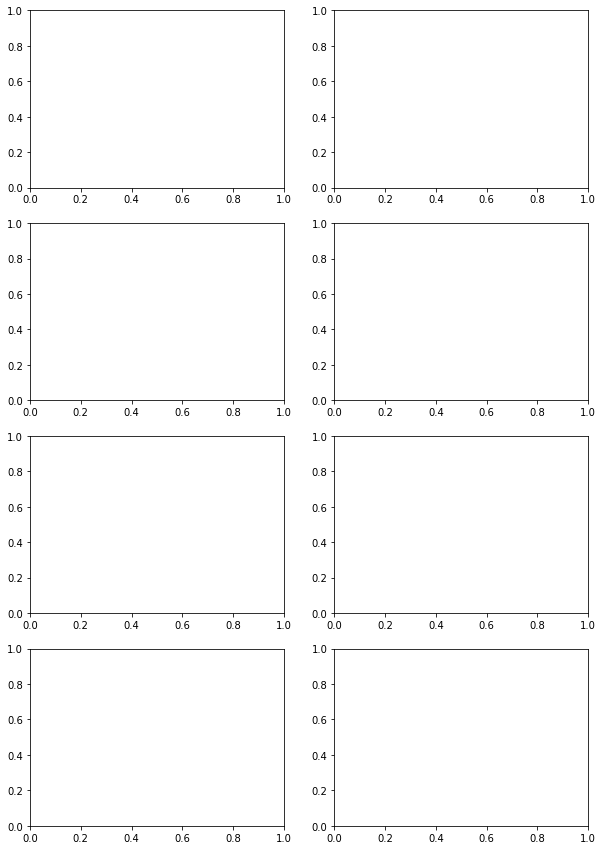

In [42]:
# TODO: Implement this! (20 points)
def subplot_results(results, metric, ax): 
    
    # get results
    result1 = [results[1][model][metric] for model in results[1]]
    result2 = [results[2][model][metric] for model in results[2]]
    
    # barwidth 
    w = 0.3
 
    r1 = np.arange(len(result1))
    r2 = [x + w for x in r1]

    # plot
    ax.bar(r1, result1, color='#ff9900', width=w, edgecolor='white', label='index set 1')
    ax.bar(r2, result2, color='#3366cc', width=w, edgecolor='white', label='index set 2')

    # add labels
    ax.set_xlabel(metric, fontweight='bold', fontsize=12)    
    ax.set_ylabel("Score")
    ax.set_xticks([r + w-0.15 for r in range(len(result1))])
    ax.set_xticklabels(['NaiveQL', 'QL', 'BM25', 'BOW', 'TF-IDF'])
    ax.legend()

    
def plot_results(results): 
    fig, axs = plt.subplots(4, 2, figsize=(10, 15))
        
    subplot_results(results, "ERR", ax=axs[0][0])
    subplot_results(results, "MAP", ax=axs[0][1])
    subplot_results(results, "Recall@1", ax=axs[1][0])
    subplot_results(results, "Recall@5", ax=axs[1][1])
    subplot_results(results, "Recall@10", ax=axs[2][0])
    subplot_results(results, "Precision@1", ax=axs[2][1])
    subplot_results(results, "Precision@5", ax=axs[3][0])
    subplot_results(results, "Precision@10", ax=axs[3][1])

    plt.tight_layout()
    plt.show()

plot_results(results)

Write a summary of what you observe in the results.
You summary should compare results across the 2 indices and the methods being used. State what you expected to see in the results, followed by either supporting evidence *or* justify why the results did not support your expectations.      
*Hint*: You may build upon the answers from the previous sections. 

*TODO: Answer this!*